In [5]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=5d69ed641710898d3c5be6873e60dca0027ffa3c2a0c0dffb672417eecdd28b6
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-04-07 00:26:41--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-04-07 00:26:41--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>] 

In [6]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF
import torchvision.transforms.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import cv2

In [7]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [8]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [9]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [10]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

        self.attention_biases = None
        self.attention_bias_idxs = None

    def compute_attention_bias(self, resolution):

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)

        attention_offsets = {}
        idxs = []

        # if N = 196, then resolution = 14
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        num_offsets = len(attention_offsets)

        # 각 attention head에 대해 num_offsets 만큼의 학습 가능한 Bias를 생성
        self.attention_biases = nn.Parameter(torch.zeros(self.num_heads, num_offsets).to(next(self.parameters()).device))
        self.attention_bias_idxs = torch.LongTensor(idxs).view(N, N).to(next(self.parameters()).device)

    def forward(self, x):
        B, N, C = x.shape
        resolution = int(N ** 0.5)

        if self.attention_biases is None or self.attention_bias_idxs.shape[0] != N:
            self.compute_attention_bias(resolution)

        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: (B, num_heads, N, N)
        attn_bias = self.attention_biases[:, self.attention_bias_idxs].unsqueeze(0) # attn_bias: (1, num_heads, N, N)
        attn = attn + attn_bias
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [11]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [12]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [13]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [14]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [15]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [17]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [18]:
model = LevitDistilled(num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [19]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [20]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [21]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = False  # 연산 속도를 희생하고 일관된 연산을 수행

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [22]:
train_dir = './train/NCT-CRC-HE-100K'

In [23]:
def elastic_transform(image, alpha, sigma):
    """탄성 변형 적용"""

    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()
    else:
        image_np = np.array(image)

    shape = image_np.shape[:2]

    ksize = 2 * int(sigma) + 1

    dx = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (ksize, ksize), sigma) * alpha
    dy = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (ksize, ksize), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

    indices = np.stack((y + dy, x + dx), axis=-1).astype(np.float32)
    distorted_image = cv2.remap(image_np, indices, None, cv2.INTER_LINEAR)

    return distorted_image

In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: elastic_transform(x, alpha=10, sigma=4)),
    transforms.ToTensor(),
])

In [25]:
import json

with open("default_index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [26]:
dataset_train = datasets.ImageFolder(root=train_dir, transform=aug_transform)
dataset_eval = datasets.ImageFolder(root=train_dir, transform=transform)

train_data = Subset(dataset_train, load_train_idx)
val_data = Subset(dataset_eval, load_val_idx)
test_data = Subset(dataset_eval, load_test_idx)

In [27]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lr=learning_rate, params=model.parameters())

In [29]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [30]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [31]:
# Global variable to track the best validation loss
best_val_loss = float('inf')

def evaluate(model, data_loader, criterion, device, epoch, phase="Validation", save_path="best_model.pth"):
    global best_val_loss  # Reference global best validation loss
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader, desc=f"{phase}")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Check if this is the best model so far (lowest validation loss)
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved with {phase} loss {epoch_loss:.4f} at {save_path}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [32]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [33]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device, epoch)
    evaluate(model, val_loader, criterion, device, epoch, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [05:21<00:00,  6.81it/s]


Train Loss: 0.5083, Train Accuracy: 82.04%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]


Validation Loss: 0.5585, Validation Accuracy: 80.85%
Balanced Accuracy: 0.8103
New best model saved with Validation loss 0.5585 at best_model.pth

Epoch 2/30


Training: 100%|██████████| 2188/2188 [05:20<00:00,  6.84it/s]


Train Loss: 0.2378, Train Accuracy: 91.85%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]


Validation Loss: 0.3588, Validation Accuracy: 87.39%
Balanced Accuracy: 0.8658
New best model saved with Validation loss 0.3588 at best_model.pth

Epoch 3/30


Training: 100%|██████████| 2188/2188 [05:20<00:00,  6.83it/s]


Train Loss: 0.1698, Train Accuracy: 94.24%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]


Validation Loss: 0.4769, Validation Accuracy: 85.25%
Balanced Accuracy: 0.8359

Epoch 4/30


Training: 100%|██████████| 2188/2188 [05:20<00:00,  6.84it/s]


Train Loss: 0.1307, Train Accuracy: 95.56%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]


Validation Loss: 0.2354, Validation Accuracy: 91.75%
Balanced Accuracy: 0.9193
New best model saved with Validation loss 0.2354 at best_model.pth

Epoch 5/30


Training: 100%|██████████| 2188/2188 [05:19<00:00,  6.84it/s]


Train Loss: 0.1009, Train Accuracy: 96.46%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]


Validation Loss: 0.4673, Validation Accuracy: 85.78%
Balanced Accuracy: 0.8492

Epoch 6/30


Training: 100%|██████████| 2188/2188 [05:20<00:00,  6.82it/s]


Train Loss: 0.0835, Train Accuracy: 97.16%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]


Validation Loss: 0.2524, Validation Accuracy: 91.73%
Balanced Accuracy: 0.9252

Epoch 7/30


Training: 100%|██████████| 2188/2188 [05:20<00:00,  6.83it/s]


Train Loss: 0.0687, Train Accuracy: 97.70%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


Validation Loss: 0.5631, Validation Accuracy: 85.63%
Balanced Accuracy: 0.8634

Epoch 8/30


Training: 100%|██████████| 2188/2188 [05:22<00:00,  6.78it/s]


Train Loss: 0.0575, Train Accuracy: 98.02%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]


Validation Loss: 0.7272, Validation Accuracy: 80.38%
Balanced Accuracy: 0.7882

Epoch 9/30


Training: 100%|██████████| 2188/2188 [05:17<00:00,  6.90it/s]


Train Loss: 0.0491, Train Accuracy: 98.26%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]


Validation Loss: 0.1210, Validation Accuracy: 96.05%
Balanced Accuracy: 0.9645
New best model saved with Validation loss 0.1210 at best_model.pth

Epoch 10/30


Training: 100%|██████████| 2188/2188 [05:15<00:00,  6.93it/s]


Train Loss: 0.0407, Train Accuracy: 98.59%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]


Validation Loss: 0.7875, Validation Accuracy: 82.53%
Balanced Accuracy: 0.8217

Epoch 11/30


Training: 100%|██████████| 2188/2188 [05:16<00:00,  6.92it/s]


Train Loss: 0.0381, Train Accuracy: 98.70%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]


Validation Loss: 0.3914, Validation Accuracy: 89.97%
Balanced Accuracy: 0.9008

Epoch 12/30


Training: 100%|██████████| 2188/2188 [05:16<00:00,  6.91it/s]


Train Loss: 0.0339, Train Accuracy: 98.80%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]


Validation Loss: 0.4840, Validation Accuracy: 90.66%
Balanced Accuracy: 0.9037

Epoch 13/30


Training: 100%|██████████| 2188/2188 [05:15<00:00,  6.93it/s]


Train Loss: 0.0299, Train Accuracy: 98.96%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.50it/s]


Validation Loss: 0.4906, Validation Accuracy: 87.91%
Balanced Accuracy: 0.8695

Epoch 14/30


Training: 100%|██████████| 2188/2188 [05:15<00:00,  6.92it/s]


Train Loss: 0.0278, Train Accuracy: 99.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]


Validation Loss: 0.1885, Validation Accuracy: 95.05%
Balanced Accuracy: 0.9472

Epoch 15/30


Training: 100%|██████████| 2188/2188 [05:15<00:00,  6.94it/s]


Train Loss: 0.0250, Train Accuracy: 99.16%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]


Validation Loss: 0.2113, Validation Accuracy: 94.39%
Balanced Accuracy: 0.9443

Epoch 16/30


Training: 100%|██████████| 2188/2188 [05:17<00:00,  6.89it/s]


Train Loss: 0.0213, Train Accuracy: 99.26%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]


Validation Loss: 0.1418, Validation Accuracy: 95.83%
Balanced Accuracy: 0.9552

Epoch 17/30


Training: 100%|██████████| 2188/2188 [05:18<00:00,  6.88it/s]


Train Loss: 0.0210, Train Accuracy: 99.23%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]


Validation Loss: 0.1690, Validation Accuracy: 95.57%
Balanced Accuracy: 0.9545

Epoch 18/30


Training: 100%|██████████| 2188/2188 [05:17<00:00,  6.90it/s]


Train Loss: 0.0191, Train Accuracy: 99.35%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]


Validation Loss: 0.1613, Validation Accuracy: 95.92%
Balanced Accuracy: 0.9554

Epoch 19/30


Training: 100%|██████████| 2188/2188 [05:16<00:00,  6.91it/s]


Train Loss: 0.0182, Train Accuracy: 99.38%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


Validation Loss: 0.9590, Validation Accuracy: 78.75%
Balanced Accuracy: 0.7832

Epoch 20/30


Training: 100%|██████████| 2188/2188 [05:16<00:00,  6.92it/s]


Train Loss: 0.0174, Train Accuracy: 99.42%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]


Validation Loss: 1.5224, Validation Accuracy: 79.87%
Balanced Accuracy: 0.7784

Epoch 21/30


Training: 100%|██████████| 2188/2188 [05:16<00:00,  6.91it/s]


Train Loss: 0.0150, Train Accuracy: 99.49%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]


Validation Loss: 0.1701, Validation Accuracy: 96.17%
Balanced Accuracy: 0.9601

Epoch 22/30


Training: 100%|██████████| 2188/2188 [05:16<00:00,  6.91it/s]


Train Loss: 0.0146, Train Accuracy: 99.50%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]


Validation Loss: 0.1191, Validation Accuracy: 97.21%
Balanced Accuracy: 0.9721
New best model saved with Validation loss 0.1191 at best_model.pth

Epoch 23/30


Training: 100%|██████████| 2188/2188 [05:16<00:00,  6.92it/s]


Train Loss: 0.0149, Train Accuracy: 99.51%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]


Validation Loss: 0.4104, Validation Accuracy: 92.45%
Balanced Accuracy: 0.9189

Epoch 24/30


Training: 100%|██████████| 2188/2188 [05:17<00:00,  6.88it/s]


Train Loss: 0.0131, Train Accuracy: 99.56%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]


Validation Loss: 0.6371, Validation Accuracy: 88.01%
Balanced Accuracy: 0.8709

Epoch 25/30


Training: 100%|██████████| 2188/2188 [05:16<00:00,  6.91it/s]


Train Loss: 0.0124, Train Accuracy: 99.59%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]


Validation Loss: 0.1340, Validation Accuracy: 96.69%
Balanced Accuracy: 0.9641

Epoch 26/30


Training: 100%|██████████| 2188/2188 [05:16<00:00,  6.90it/s]


Train Loss: 0.0117, Train Accuracy: 99.59%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]


Validation Loss: 0.1883, Validation Accuracy: 96.08%
Balanced Accuracy: 0.9597

Epoch 27/30


Training: 100%|██████████| 2188/2188 [05:19<00:00,  6.84it/s]


Train Loss: 0.0111, Train Accuracy: 99.60%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]


Validation Loss: 0.1530, Validation Accuracy: 96.21%
Balanced Accuracy: 0.9596

Epoch 28/30


Training: 100%|██████████| 2188/2188 [05:22<00:00,  6.79it/s]


Train Loss: 0.0107, Train Accuracy: 99.66%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]


Validation Loss: 0.4236, Validation Accuracy: 93.28%
Balanced Accuracy: 0.9283

Epoch 29/30


Training: 100%|██████████| 2188/2188 [05:25<00:00,  6.71it/s]


Train Loss: 0.0104, Train Accuracy: 99.66%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]


Validation Loss: 1.0048, Validation Accuracy: 84.85%
Balanced Accuracy: 0.8319

Epoch 30/30


Training: 100%|██████████| 2188/2188 [05:32<00:00,  6.58it/s]


Train Loss: 0.0098, Train Accuracy: 99.68%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]

Validation Loss: 0.0944, Validation Accuracy: 97.82%
Balanced Accuracy: 0.9774
New best model saved with Validation loss 0.0944 at best_model.pth


In [34]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [35]:
print("\nFinal Test Evaluation")
evaluate(model,test_loader, criterion, device, epoch, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]

Test Loss: 0.0927, Test Accuracy: 97.75%
Balanced Accuracy: 0.9769
New best model saved with Test loss 0.0927 at best_model.pth


In [36]:
print("train_loss length : ", len(train_losses))
print("train_acc length : ", len(train_accuracies))
print("val_loss length : ", len(val_losses))
print("val_acc length : ", len(val_accuracies))

print("val_adj : ", len(val_losses[:num_epochs]))
print("val_acc_adj : ", len(val_accuracies[:num_epochs]))

train_loss length :  30
train_acc length :  30
val_loss length :  31
val_acc length :  31
val_adj :  30
val_acc_adj :  30


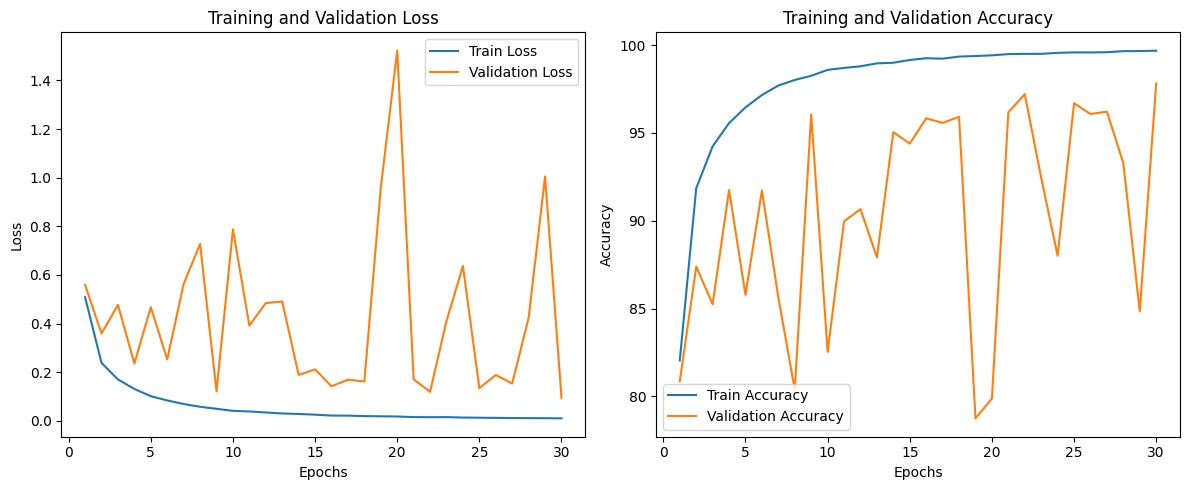

In [37]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses[:num_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies[:num_epochs], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 6.52 ms
Standard Deviation: 0.33 ms
Maximum Time: 8.80 ms
Minimum Time: 6.13 ms


In [39]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul        16.70%       3.440ms        42.82%       8.818ms     367.403us       0.000us         0.00%       2.531ms     105.438us            24  
                                           aten::linear         0.47%      96.846us        23.33%       4.803ms     266.855us       0.000us         0.00%       1.825ms     101.373us            18  
         

In [40]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [41]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [42]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]

Test Loss: 0.0927, Test Accuracy: 97.75%
Overall - F1: 0.9775, Recall: 0.9769, Precision: 0.9790
Per-Class Metrics:
Class 0 - F1: 0.9968, Recall: 0.9955, Precision: 0.9981
Class 1 - F1: 0.9978, Recall: 0.9981, Precision: 0.9975
Class 2 - F1: 0.9655, Recall: 0.9873, Precision: 0.9446
Class 3 - F1: 0.9968, Recall: 0.9965, Precision: 0.9971
Class 4 - F1: 0.9850, Recall: 0.9835, Precision: 0.9865
Class 5 - F1: 0.9660, Recall: 0.9877, Precision: 0.9453
Class 6 - F1: 0.9848, Recall: 0.9871, Precision: 0.9826
Class 7 - F1: 0.9223, Recall: 0.8749, Precision: 0.9751
Class 8 - F1: 0.9827, Recall: 0.9814, Precision: 0.9841


<Figure size 2000x1200 with 0 Axes>

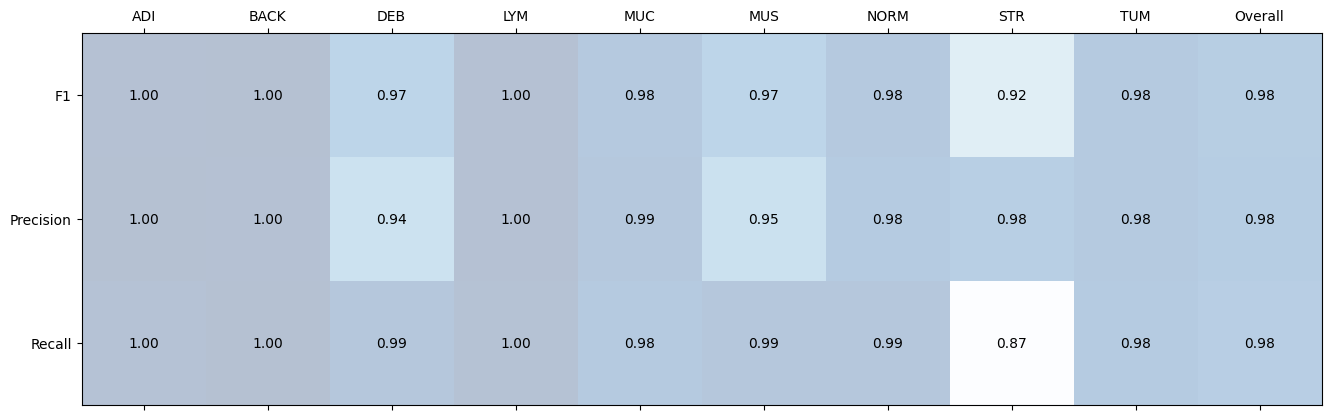

In [43]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )